## This is a data set I found on kaggle and I wanted to use my MBA back ground to see what I could forecast for the walmart store sales.

Data set @ Kaggle: [Link](https://www.kaggle.com/datasets/rutuspatel/walmart-dataset-retail)

**Business Objectives**

Develop a predictive model to forecast weekly sales for Walmart stores, leveraging historical data. Additionally, conduct a thorough analysis to identify and quantify the key variables that significantly influence sales performance.

**Background**

Dataset Description :

This is the historical data that covers sales from 2010-02-05 to 2012-11-01, in the file Walmart_Store_sales. Within this file you will find the following fields:

Store - the store number

Date - the week of sales

Weekly_Sales - sales for the given store

Holiday_Flag - whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week

Temperature - Temperature on the day of sale

Fuel_Price - Cost of fuel in the region

CPI – Prevailing consumer price index

Unemployment - Prevailing unemployment rate

Holiday Events
Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

Analysis Tasks

Basic Statistics tasks

1) Which store has maximum sales

2) Which store has maximum standard deviation i.e., the sales vary a lot. Also, find out the coefficient of mean to standard deviation

3) Which store/s has good quarterly growth rate in Q3’2012

4) Some holidays have a negative impact on sales. Find out holidays which have higher sales than the mean sales in non-holiday season for all stores together

5) Provide a monthly and semester view of sales in units and give insights

Statistical Model

For Store 1 – Build prediction models to forecast demand

Linear Regression – Utilize variables like date and restructure dates as 1 for 5 Feb 2010 (starting from the earliest date in order). Hypothesize if CPI, unemployment, and fuel price have any impact on sales.

Change dates into days by creating new variable.

Select the model which gives best accuracy.

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv
import IPython
from sklearn.ensemble import RandomForestRegressor
from pmdarima import auto_arima
from sklearn.cluster import KMeans
import warnings 

In [2]:
df = pd.read_csv('Walmart.csv')

In [3]:
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


From inspecting the data set above ive noticed there are some key economic column factors that are included for each row. 

They are: 

[Holiday_Flag]

[Fuel_Price]

[CPI](Consumer Price Index: measures the average change over time in the prices paid by urban consumers for a basket of consumer goods and services. It's a widely used indicator for measuring inflation and economic performance)

[Unemployment](Rate of unemployment)

Understaning the importance of these indicators I will first aim to find any correlation between weekly sales and any indicator provided. 

## Data Mining

In [4]:
#df['Date'].dtype ## Date collumn is stored as string and will need to be converted to a datetime data type
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y') # Convert to datetime

#df['Store'].dtype ## Store collumn is stored as an integer and I will convert it to categorical 
df['Store'] = df['Store'].astype('category') # Convert to categorical



In [5]:
#Checking for missing values. I can actually do this by using DataWrangler in VSCODE. However, I still created a function to display it on my notebook.
def countna(df):
    return df.isna().sum()
mis_val_count = countna(df)
mis_val_count # no missing values 


Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

Extracting additional date-related features: Using the .dt accessor to extract additional features such as day of the week, month, quarter, year, etc. Then adding them as new columns to the DataFrame.

In [6]:
# Extract additional date-related features
df['Month'] = df['Date'].dt.month            # Month (1-12)
df['Quarter'] = df['Date'].dt.quarter        # Quarter (1-4)
df['Year'] = df['Date'].dt.year              # Year


#rearranging newly created collumns
new_column_order = ['Store', 'Date', 'Month', 'Quarter', 'Year', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
df = df[new_column_order]

In [7]:
df

,Store,Date,Month,Quarter,Year,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,2,1,2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,2,1,2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,2,1,2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,2,1,2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,3,1,2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,9,3,2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,2012-10-05,10,4,2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,2012-10-12,10,4,2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,2012-10-19,10,4,2012,718125.53,0,56.47,3.969,192.330854,8.667


## Visulizations: EDA

In [8]:
#Syle:
sns.set_palette("Spectral")
sns.set_style("white")


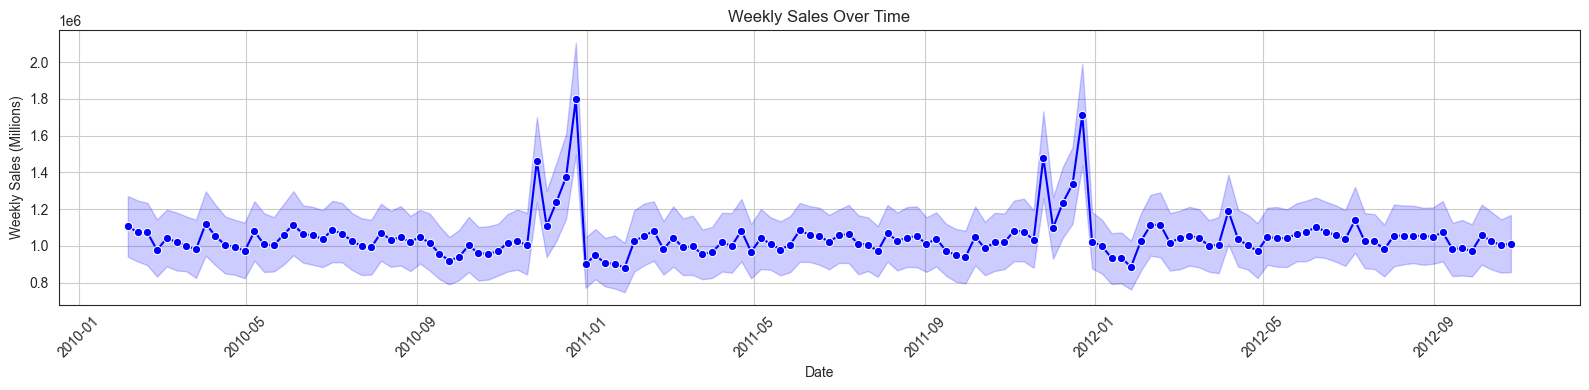

In [9]:
#Time Series Plot of Weekly Sales: Plot the weekly sales over time to visualize the overall trend and seasonal patterns. This can help identify trends, seasonality, and any anomalies in the sales data.


# Plot weekly sales over time using seaborn
plt.figure(figsize=(16, 4))
sns.lineplot(data=df, x='Date', y='Weekly_Sales', marker='o', color='b')
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales (Millions)')
plt.grid(True) 
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

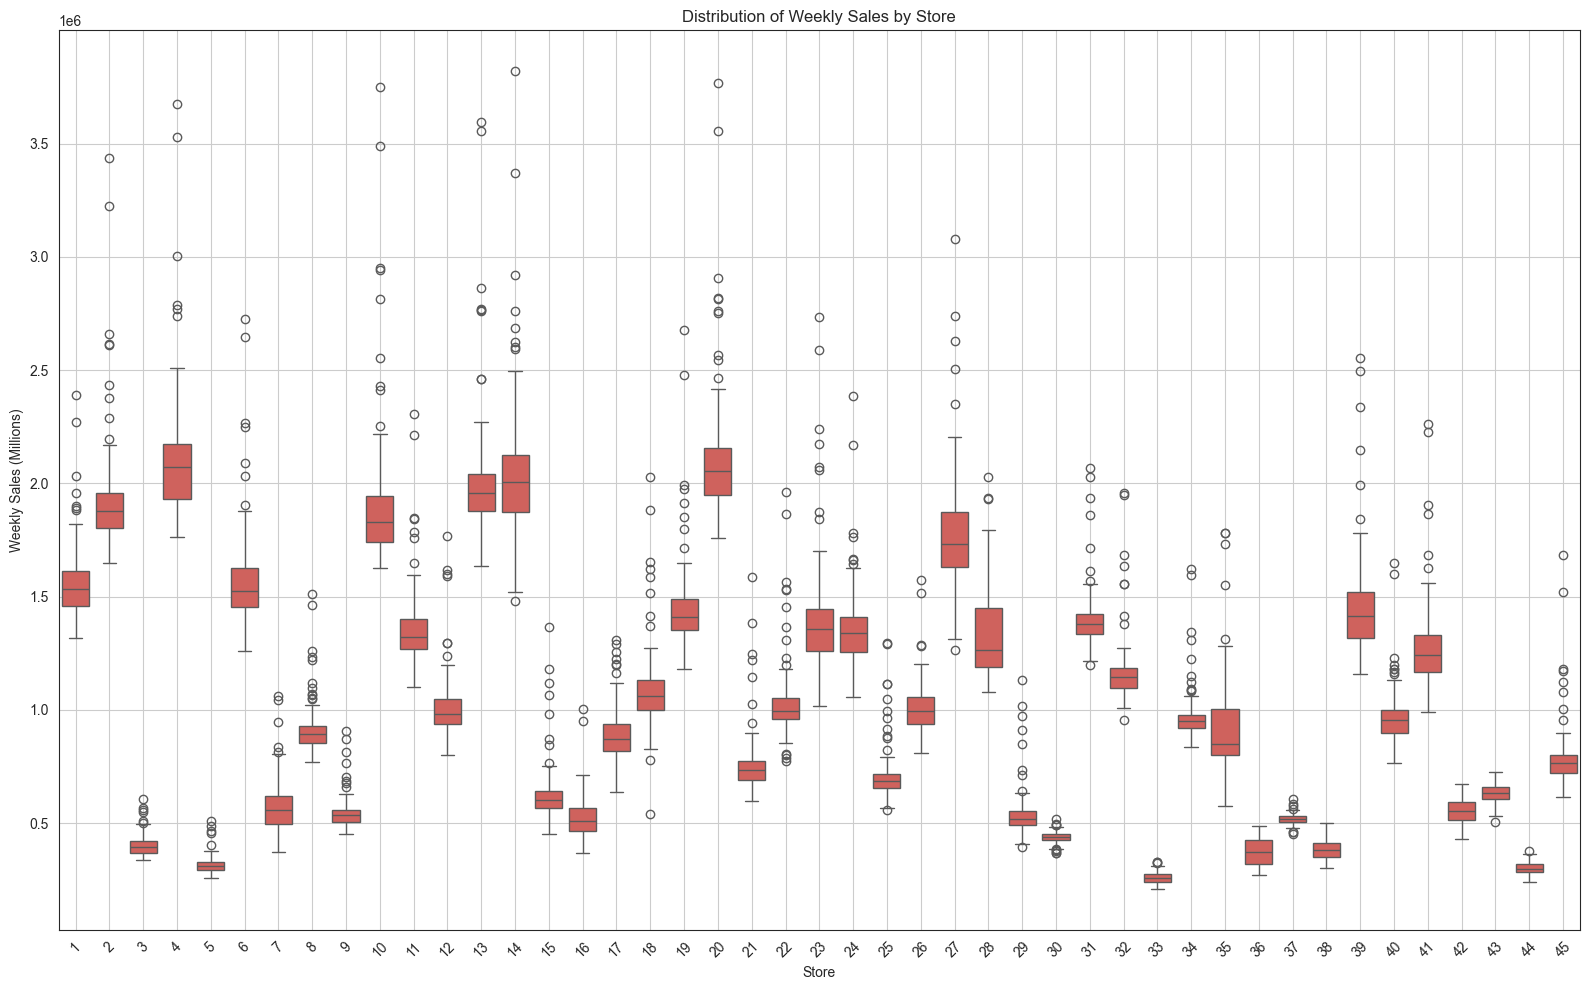

In [10]:
#Box Plot of Weekly Sales by Store: Create a box plot to visualize the distribution of weekly sales across different stores. 
#This can help identify variations in sales performance between stores and potential outliers.


# Create a box plot of weekly sales by store
plt.figure(figsize=(16, 10))
sns.boxplot(data=df, x='Store', y='Weekly_Sales')
plt.title('Distribution of Weekly Sales by Store')
plt.xlabel('Store')
plt.ylabel('Weekly Sales (Millions)')
plt.xticks(rotation=45)
plt.grid(True) 
plt.tight_layout()  
plt.show()

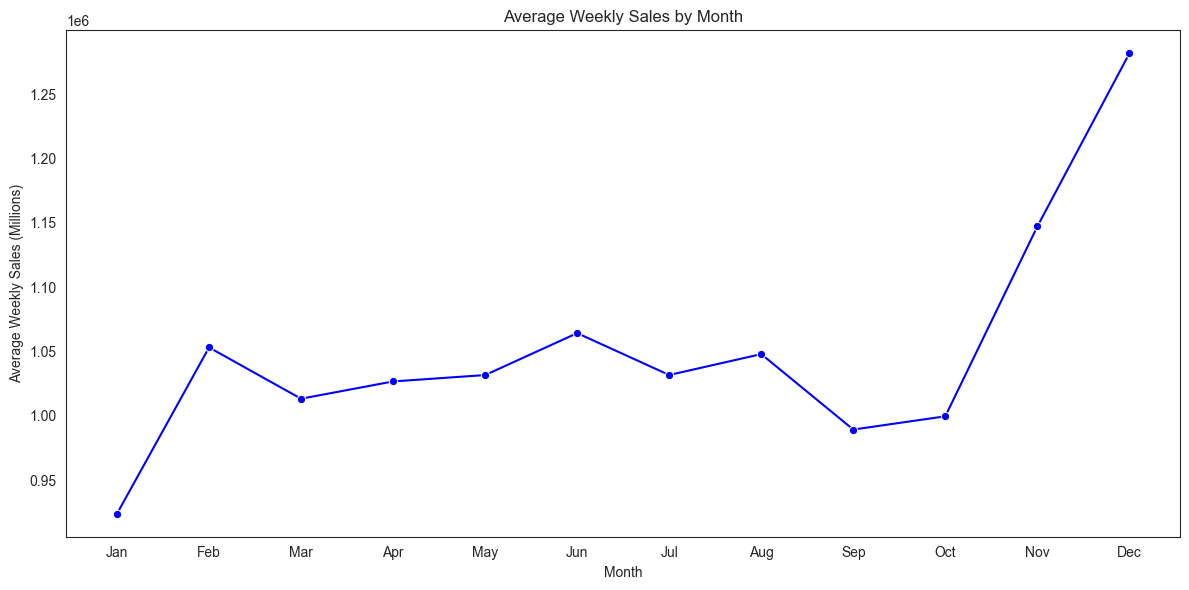

In [11]:
#Line Plot of Weekly Sales by Month: Plot the average weekly sales for each month to visualize the monthly trend in sales over the years. 
#This can help identify any seasonal patterns or trends in sales over time.

average_sales_by_month = df.groupby('Month')['Weekly_Sales'].mean().reset_index() # Calculating the average weekly sales for each month

# Plot the average weekly sales by month
plt.figure(figsize=(12, 6))
sns.lineplot(data=average_sales_by_month, x='Month', y='Weekly_Sales', marker='o', color='b')
plt.title('Average Weekly Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales (Millions)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

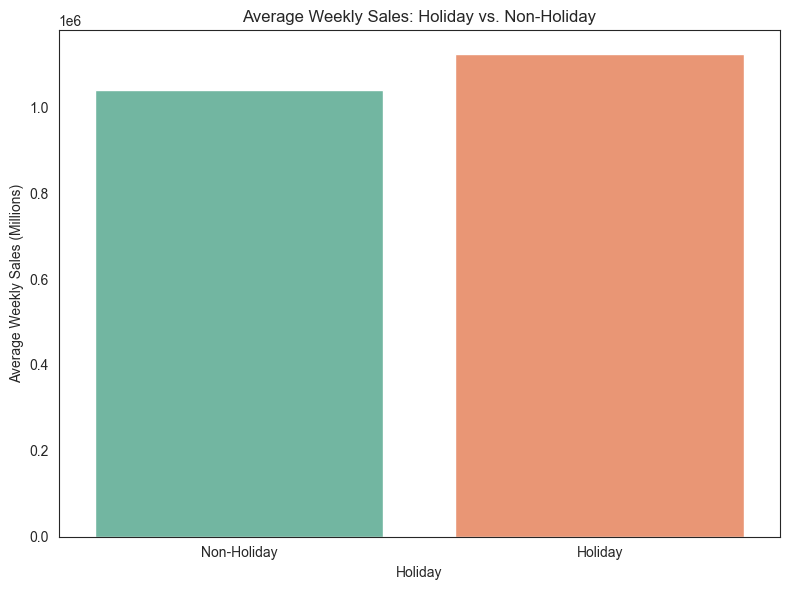

In [12]:
#Bar Plot of Holiday vs. Non-Holiday Sales: Create a bar plot to compare the average weekly sales during holiday weeks versus non-holiday weeks. This can help assess the impact of holidays on sales.

average_sales_by_holiday = df.groupby('Holiday_Flag')['Weekly_Sales'].mean().reset_index() # Calculating average weekly sales for holiday and non-holiday weeks

# Plot the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=average_sales_by_holiday, x='Holiday_Flag', y='Weekly_Sales', hue='Holiday_Flag', palette='Set2', dodge=False, legend=False)
plt.title('Average Weekly Sales: Holiday vs. Non-Holiday')
plt.xlabel('Holiday')
plt.ylabel('Average Weekly Sales (Millions)')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])  
plt.tight_layout()
plt.show()

In [13]:
#Scatter Plot of Weekly Sales vs. Temperature: Plot weekly sales against temperature to visualize the relationship between sales and temperature. This can help identify any correlation or patterns between sales and weather conditions.

#Correlation Heatmap: Create a heatmap to visualize the correlation matrix between different numerical variables such as weekly sales, temperature, fuel price, CPI, and unemployment rate. This can help identify variables that are strongly correlated with weekly sales.

#Histogram of Weekly Sales: Plot a histogram of weekly sales to visualize the distribution of sales values. This can help assess the skewness and spread of the sales data.

## Feature Importance from Tree-Based Models: Tree-based models like Random Forest

In [14]:
# Ensure 'Date' column is correctly converted to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Check the data types of all columns
print(df.dtypes)

Store                 category
Date            datetime64[ns]
Month                    int32
Quarter                  int32
Year                     int32
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object


In [15]:
# Separate features and target variable
# Exclude non-numeric columns from features
X = df.drop(['Weekly_Sales', 'Date'], axis=1)
y = df['Weekly_Sales']

# Initialize Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_regressor.fit(X, y)

# Extract feature importances
feature_importances = rf_regressor.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

        Feature  Importance
0         Store    0.670305
7           CPI    0.159747
8  Unemployment    0.102543
1         Month    0.027901
5   Temperature    0.017945
6    Fuel_Price    0.012981
4  Holiday_Flag    0.005785
3          Year    0.001902
2       Quarter    0.000891


**Breakdown of the feature importances:**

**Store (0.670305)**: This feature has the highest importance, indicating that it has the most significant impact on predicting weekly sales. It suggests that different stores might have different sales patterns or behaviors that significantly influence sales.

**CPI (0.159747):** The Consumer Price Index (CPI) comes next in importance, suggesting that economic factors captured by CPI play a significant role in sales forecasting. Changes in CPI can reflect inflation rates, which might affect consumer spending behavior.

**Unemployment (0.102543):** Unemployment rate follows in importance, indicating that labor market conditions could also impact sales. Higher unemployment rates might lead to decreased consumer confidence and spending.

**Month (0.027901):** The month feature suggests that there might be some seasonality in sales, with certain months having higher or lower sales volumes.

**Temperature (0.017945):** Temperature also shows some importance, indicating that weather conditions might influence consumer behavior and affect sales.

**Fuel_Price (0.012981):** Fuel prices have a smaller but still notable importance, suggesting that changes in fuel prices could impact transportation costs and, consequently, sales patterns.

**Holiday_Flag (0.005785):** The holiday flag feature indicates whether a given week includes a holiday. While it has some importance, it's relatively lower compared to other features.

**Year (0.001902):** The year feature has the least importance, indicating that year-over-year changes might not have as significant an impact on sales compared to other factors.

**Quarter (0.000891):** Similarly, the quarter feature also has low importance, suggesting that sales patterns might not vary significantly across quarters.

## Model Selection 

For model selection given the feature importances described above and the overall business objective ive decided to go with **SARIMA (Seasonal AutoRegressive Integrated Moving Average).**

SARIMA models are specifically designed to handle time series data with seasonal patterns, making them a natural choice for sales forecasting tasks where seasonality is likely to be present. Since you've already identified features like month and holiday flag, SARIMA models can incorporate these seasonal and holiday effects into the forecasting process. Additionally, SARIMA models are relatively interpretable and can provide insights into the underlying seasonal and autoregressive patterns in the data.


The SARIMA model is represented by the following equation:

$$ Y_t = \phi_1 Y_{t-1} + \cdots + \phi_p Y_{t-p} + \theta_1 \varepsilon_{t-1} + \cdots + \theta_q \varepsilon_{t-q} + \epsilon_t $$

Where:
\( Y_t \) is the value of the time series at time \( t \),


\( \phi_1, \ldots, \phi_p \) are the autoregressive coefficients,


\( Y_{t-1}, \ldots, Y_{t-p} \) are the lagged values of the time series,


\( \theta_1, \ldots, \theta_q \) are the moving average coefficients,


\( \varepsilon_{t-1}, \ldots, \varepsilon_{t-q} \) are the lagged forecast errors,


\( \epsilon_t \) is the error term at time \( t \).


In [16]:
warnings.filterwarnings('ignore')

In [23]:
# Sort DataFrame by the 'Date' column
sarima_df = df.drop(['Month', 'Quarter', 'Year'], axis=1)
sarima_df.sort_values(by='Date', inplace=True)

#Start date for the test data
test_start_date = '2012-01-02'  # One day after the end of the training data

# Extract the test data
test = sarima_df.set_index('Date')['Weekly_Sales'].loc[test_start_date:]

#End date for training data
train_end_date = '2012-01-01'

# Extract the training data
train = sarima_df.set_index('Date')['Weekly_Sales'].loc[:train_end_date]


sarima_model = auto_arima(train, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=134993.171, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=132134.016, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=132097.603, Time=0.55 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=132082.324, Time=0.68 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=132072.160, Time=1.45 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=132065.445, Time=1.88 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=133734.005, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=132133.886, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=132087.111, Time=0.67 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=132078.125, Time=0.84 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=132073.001, Time=1.06 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=133174.774, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=132134.687, Time=0.65 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=132087.497, Time=1.27 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=132072

In [24]:
# Print model summary
print(sarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4500
Model:               SARIMAX(0, 1, 5)   Log Likelihood              -66025.723
Date:                Sat, 24 Feb 2024   AIC                         132065.445
Time:                        00:27:12   BIC                         132110.327
Sample:                             0   HQIC                        132081.260
                               - 4500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -37.1715    136.816     -0.272      0.786    -305.327     230.984
ma.L1         -0.9614      0.015    -65.552      0.000      -0.990      -0.933
ma.L2         -0.0089      0.021     -0.431      0.6

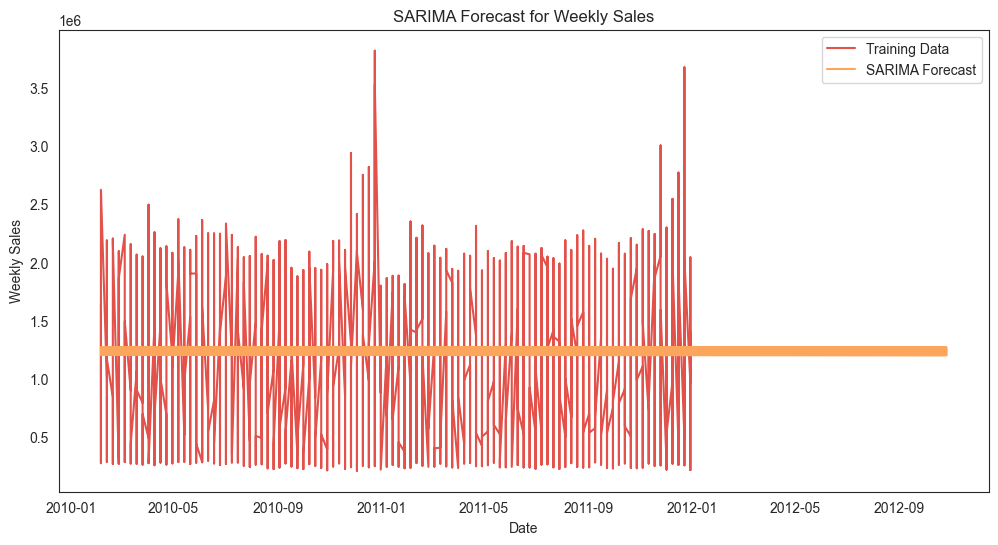

In [25]:
# Forecast
n_forecast = len(df.set_index('Date')) - len(train)
forecast = sarima_model.predict(n_periods=n_forecast)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(df.set_index('Date').index[len(train):], forecast, label='SARIMA Forecast')
plt.title('SARIMA Forecast for Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

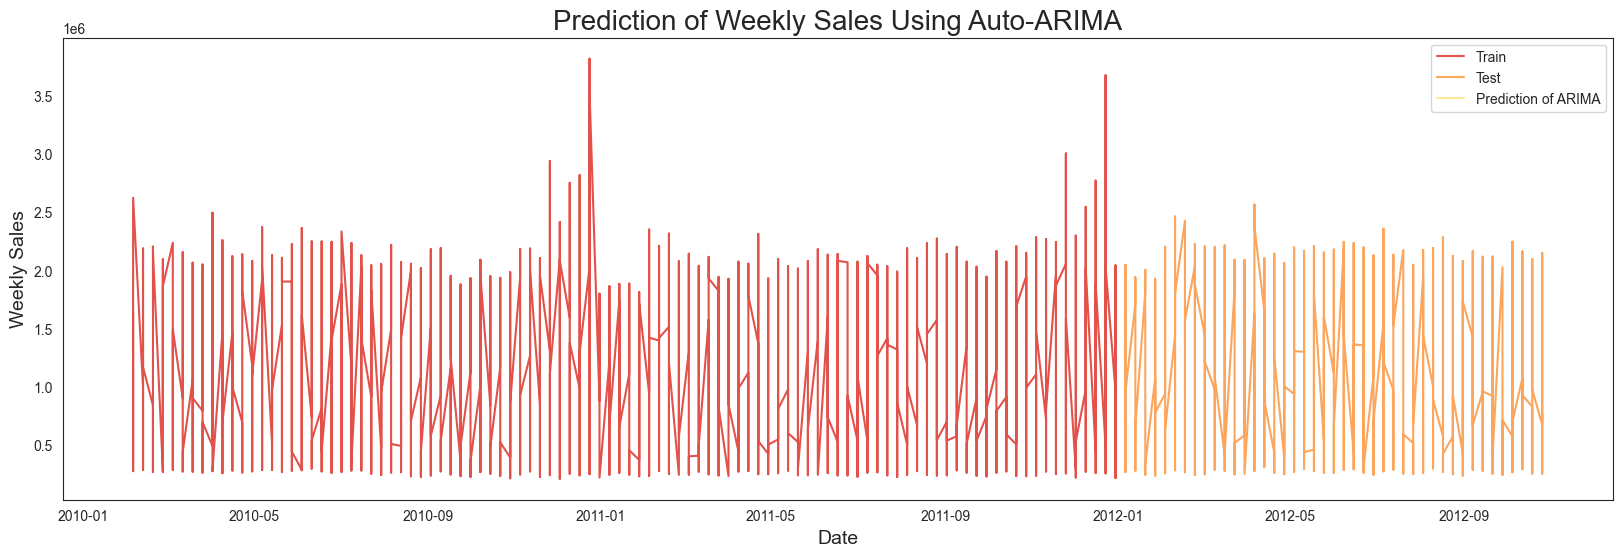

In [28]:
y_pred = sarima_model.predict(n_periods=len(test))
y_pred = pd.DataFrame(y_pred,index = test.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()